In [1]:
import networkx as nx
import pandas as pd
from tqdm import tqdm_notebook,tqdm
import numpy as np
parent_path='../Data/New_Data_15-06-2020/'

In [8]:
annotated_df=pd.read_pickle(parent_path+'Fearspeech_data_final.pkl')
whatsapp_data=pd.read_csv(parent_path+'Data_text_spam_removed_v02.csv')
temp=whatsapp_data[['group_id_anonymized','phone_num_anonymized','message_text','timestamp']]
duplicateDFRow = temp[temp.duplicated()]
whatsapp_data=whatsapp_data.drop(list(duplicateDFRow.index))


In [27]:
whatsapp_data=whatsapp_data.sort_values('timestamp')


In [2]:
df_user_matched=pd.read_csv(parent_path+'final_user_selection_matched.csv')

In [49]:
len(df_user_matched[df_user_matched['annotation']=='Non fear speech'])

2935

In [11]:
dict_users_ids={}
dict_users_names={}
dict_users_groups={}  
count=0
for user in tqdm(whatsapp_data['phone_num_anonymized'].unique()):
    if user in annotated_df.phone_num_anonymized.unique():
        dict_users_ids[count]=user
        dict_users_names[count]='fear speech'
    else:
        dict_users_ids[count]=user
        dict_users_names[count]='normal'
        
    dict_users_groups[count]=set(whatsapp_data[whatsapp_data['phone_num_anonymized']==user].group_id_anonymized)
    count+=1

100%|██████████| 167905/167905 [05:16<00:00, 529.99it/s]


In [13]:
tuples_user_info=[]
for user1 in tqdm(dict_users_ids):
    for user2 in dict_users_ids:
        if(user1==user2):
            continue
        temp_user1_groups= dict_users_groups[user1]
        temp_user2_groups= dict_users_groups[user2]
        common_groups=len(temp_user1_groups.intersection(temp_user2_groups))
        if(common_groups>0):
            tuples_user_info.append([user1,user2,common_groups])

100%|██████████| 167905/167905 [3:02:50<00:00, 15.31it/s]  


In [15]:
import networkx as nx

In [17]:
G = nx.Graph()


In [18]:
G.add_weighted_edges_from(tuples_user_info)

In [24]:
k_cores=nx.algorithms.core.k_crust()

In [37]:
all_fear_speech_index=[]
all_normal_index=[]

count_fearspeech=0
count_normal=0

for index,row in tqdm(annotated_df.iterrows(),total=len(annotated_df)):
    if(row['one_fear_speech']==1):
        count_fearspeech+=1
        all_fear_speech_index+=row['repeated']
    elif(row['one_fear_speech']==0):
        count_normal+=1
        all_normal_index+=row['repeated']

data_fear_speech=whatsapp_data[whatsapp_data['orig_index'].isin(all_fear_speech_index)]
data_normal=whatsapp_data[whatsapp_data['orig_index'].isin(all_normal_index)]


100%|██████████| 4782/4782 [00:02<00:00, 2163.77it/s]


In [112]:
len(data_fear_speech.phone_num_anonymized.unique())

2935

In [115]:
list_messages=[]
for user in data_fear_speech.phone_num_anonymized.unique():
    temp_user=data_fear_speech[data_fear_speech['phone_num_anonymized']==user]
    list_messages.append(len(temp_user))
    



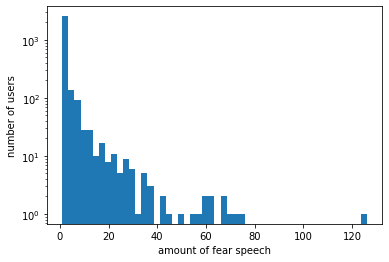

In [116]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(list_messages, bins = 50)
plt.xlabel('amount of fear speech')
plt.ylabel('number of users')
plt.yscale('log')
plt.show()

In [75]:
list_cores=[]
for user in data_fear_speech.phone_num_anonymized.unique():
    try:
        list_cores.append(k_cores[int(user)])
    except:
        list_cores.append(0)

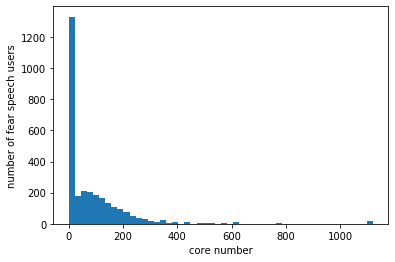

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(list_cores, bins = 50)
plt.xlabel('core number')
plt.ylabel('number of fear speech users')
plt.show()

In [70]:
user_nfs=df_user_matched[df_user_matched['annotation']=='Non fear speech'].user_id

In [71]:
df_user_matched

,user_id,annotation
0,103959,Fear speech
1,241507,Fear speech
2,219396,Fear speech
3,13625,Fear speech
4,150350,Fear speech
...,...,...
5865,151434,Non fear speech
5866,37388,Non fear speech
5867,33435,Non fear speech
5868,63851,Non fear speech


In [78]:
list_cores=[]
for user in user_nfs:
    try:
        list_cores.append(k_cores[int(user)])
    except:
        list_cores.append(0)

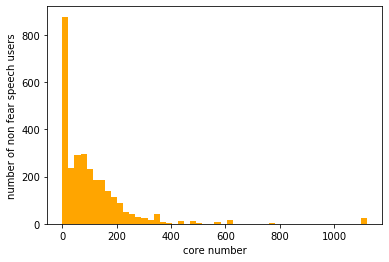

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(list_cores, bins = 50,color='orange')
plt.xlabel('core number')
plt.ylabel('number of non fear speech users')
plt.show()

In [5]:
admin_data=pd.read_csv(parent_path+'group_membership.csv',sep='\t')
admin_data[admin_data['is_admin']!=0]

,group_id,user_id,is_admin
2,56,5150,1
14,56,519,1
15,56,3141,2
22,56,2329,1
32,56,9277,1
...,...,...,...
267484,9976,233159,1
267485,9976,249609,1
267486,9976,249610,1
267487,9977,249611,1


In [6]:
num_spreader=[]
for index,row in tqdm(df_user_matched.iterrows(),total=len(df_user_matched)):
    try:
        temp=admin_data[admin_data['user_id']==row['user_id']].group_id.nunique()
    except KeyError:
        temp=0
    num_spreader.append([row['user_id'],temp,row['annotation']])
    

100%|██████████| 5870/5870 [00:05<00:00, 1098.44it/s]


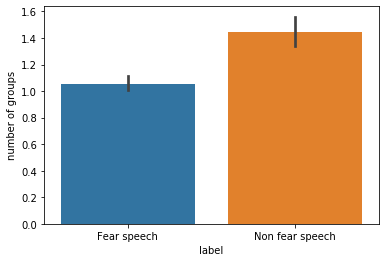

In [7]:
import seaborn as sns

df_num_users=pd.DataFrame(num_spreader,columns=['user_id','number of groups','label'])
ax1 = sns.barplot(x="label", y="number of groups", data=df_num_users)

In [9]:
all_fear_speech_index=[]
all_normal_index=[]

count_fearspeech=0
count_normal=0

for index,row in tqdm(annotated_df.iterrows(),total=len(annotated_df)):
    if(row['one_fear_speech']==1):
        count_fearspeech+=1
        all_fear_speech_index+=row['repeated']
    elif(row['one_fear_speech']==0):
        count_normal+=1
        all_normal_index+=row['repeated']

data_fear_speech=whatsapp_data[whatsapp_data['orig_index'].isin(all_fear_speech_index)]
data_normal=whatsapp_data[whatsapp_data['orig_index'].isin(all_normal_index)]


100%|██████████| 4782/4782 [00:00<00:00, 14421.40it/s]


In [ ]:
temp=data_fear_speech.sample(1)
whatsapp_data[(whatsapp_data['group_id_anonymized']==temp.iloc[0]['group_id_anonymized']) & (whatsapp_data['timestamp'].between(temp.iloc[0]['timestamp'],temp.iloc[0]['timestamp']+(2*24*60*60*1000) , inclusive=True))]

In [42]:
user_actions=pd.read_csv(parent_path+'user_actions.csv',sep='\t')
user_actions=user_actions.sort_values('timestamp')

In [50]:
user_actions.head()

,group_id,user_id,timestamp,action,action_by_user
290489,7949,199778,1538120798,added_by_admin,NaN
290564,7949,239924,1538120798,added_by_admin,NaN
290563,7949,199162,1538120798,added_by_admin,NaN
290562,7949,198507,1538120798,added_by_admin,NaN
290561,7949,239923,1538120798,added_by_admin,NaN


In [99]:
count_no_left=0
time_to_leave=[]
for index,row in tqdm_notebook(data_fear_speech.iterrows(),total=len(data_fear_speech)):
    temp_action=user_actions[(user_actions['timestamp']>int(row['timestamp']/1000))&(user_actions['group_id']==row['group_id_anonymized'])&(user_actions['user_id']==row['phone_num_anonymized'])]
    flag=0
    if(len(temp_action)==0):
        count_no_left+=1
        continue
    for index1,row1 in temp_action.iterrows():
        if(row1['action'] in ['removed']):
            time_shift=(row1['timestamp']-int(row['timestamp']/1000))/(24*60*60)
            time_to_leave.append(time_shift)
            flag=1
            break
    if(flag==0):
        count_no_left+=1
        
           
    
        
        

/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [100]:
len(time_to_leave)/len(data_fear_speech)

0.03682466870540265

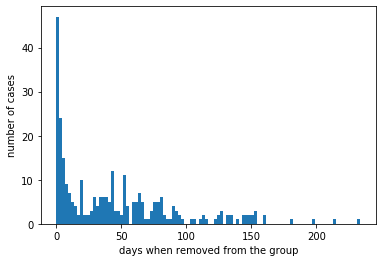

In [102]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(time_to_leave, bins = 100)
plt.xlabel('days when removed from the group')
plt.ylabel('number of cases')
plt.show()

In [103]:
user_actions.action.unique()

array(['added_by_admin', 'added', 'joined_via_link', 'left', 'removed',
       'number_changed'], dtype=object)

### Groups

In [113]:
list_messages=[]
for user in data_fear_speech.group_id_anonymized.unique():
    temp_user=data_fear_speech[data_fear_speech['group_id_anonymized']==user]
    list_messages.append(len(temp_user))

In [117]:
data_fear_speech.group_id_anonymized.nunique()

950

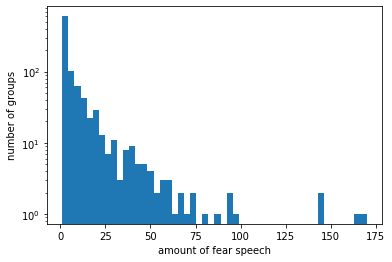

In [114]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(list_messages, bins = 50)
plt.xlabel('amount of fear speech')
plt.ylabel('number of groups')
plt.yscale('log')
plt.show()